In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')

In [3]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [27]:
base = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year','fuel_efficiency_mpg']
base_df = df[base]
base_df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

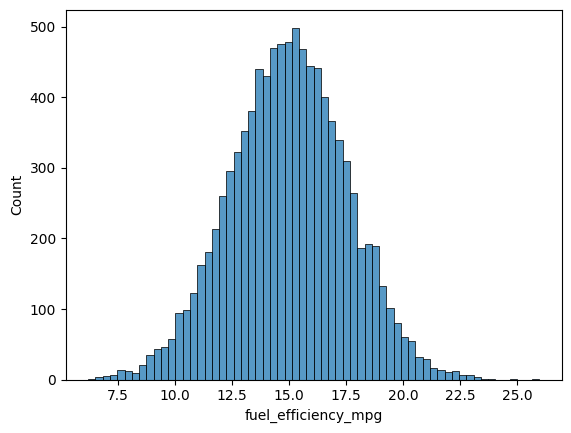

In [28]:
sns.histplot(df['fuel_efficiency_mpg'])

#### Question 1

There's one column with missing values. What is it?

In [29]:
base_df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

#### Question 2

What's the median (50% percentile) for variable 'horsepower'?

In [30]:
base_df['horsepower'].median()

149.0

In [31]:
n = len(base_df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [32]:
n_val, n_test, n_train

(1940, 1940, 5824)

In [33]:
idx = np.arange(n)

In [34]:
np.random.seed(42)
np.random.shuffle(idx)

In [35]:
df_train = base_df.iloc[idx[n_train:]]
df_val = base_df.iloc[idx[n_train:n_train+n_val]]
df_test = base_df.iloc[idx[n_train+n_val:]]

In [37]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#### Question 3

- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

Options:
 - With 0
 - With mean
 - Both are equally good


In [64]:
X_train_0 = df_train.fillna(0).values
X_val_0 = df_val.fillna(0).values
X_train_mean = df_train.fillna(df_train['horsepower'].mean()).values
X_val_mean = df_val.fillna(df_val['horsepower'].mean()).values

In [68]:
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values

In [69]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0]) # bias term
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [70]:
w00, w0 = train_linear_regression(X_train_0, y_train)
w0mean, wmean = train_linear_regression(X_train_mean, y_train)

In [71]:
y_pred0 = w00 + X_val_0.dot(w0)
y_predmean = w0mean + X_val_mean.dot(wmean)

In [95]:
def rmse(y, y_pred):
    error = y - y_pred
    se = error ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [73]:
rmse_0 = rmse(y_val, y_pred0)
rmse_mean = rmse(y_val, y_predmean)
print(f"RMSE for missing values with 0 is: {round(rmse_0,2)}")
print(f"RMSE for missing values with mean is: {round(rmse_mean,2)}")

RMSE for missing values with 0 is: 0.0
RMSE for missing values with mean is: 0.0


#### Question 4

- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?
- If there are multiple options, select the smallest r.

In [77]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0]) # bias term
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [83]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w00, w0 = train_linear_regression_reg(X_train_0, y_train, r)
    y_pred0 = w00 + X_val_0.dot(w0)
    rmse_0 = rmse(y_val, y_pred0)
    print(f"RMSE for missing values with 0 with regularization {r} is: {round(rmse_0,6)}")

RMSE for missing values with 0 with regularization 0 is: 0.0
RMSE for missing values with 0 with regularization 0.01 is: 5e-06
RMSE for missing values with 0 with regularization 0.1 is: 4.9e-05
RMSE for missing values with 0 with regularization 1 is: 0.000491
RMSE for missing values with 0 with regularization 5 is: 0.002445
RMSE for missing values with 0 with regularization 10 is: 0.004868
RMSE for missing values with 0 with regularization 100 is: 0.044914


#### Question 5

- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))
- What's the value of std?

In [123]:
idx = np.arange(n)

def preprocess(df, s):
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[n_train:]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values
    X_test = df_test.fillna(0).values
    y_train = df_train['fuel_efficiency_mpg'].values
    y_val = df_val['fuel_efficiency_mpg'].values
    y_test = df_test['fuel_efficiency_mpg'].values

    return X_train, X_val, X_test, y_train, y_val, y_test

In [116]:
rmse_scores = []
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    X_train, X_val, X_test, y_train, y_val, y_test = preprocess(base_df, s)
    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)
    rmse_scores.append(rmse(y_val, y_pred))
    
rmse_scores = np.array(rmse_scores)
rmse_std = np.std(rmse_scores)
print(round(rmse_std,3))

0.0


#### Question 6

- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [124]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(base_df, 9)

print(len(X_train), len(X_val), len(X_train) + len(X_val))
X_train_combined = np.append(X_train, X_val, axis=0)
print(len(X_train_combined))

print(len(y_train), len(y_val), len(y_train) + len(y_val))
y_train_combined = np.append(y_train, y_val, axis=0)
print(len(y_train_combined))

3880 1940 5820
5820
3880 1940 5820
5820


In [132]:
w0, w = train_linear_regression_reg(X_train_combined, y_train_combined, r=0.001)
y_pred = w0 + X_test.dot(w)
rmse_value = rmse(y_test, y_pred)
print(round(rmse_value,6))

0.0
